# Frequency Conversion-Indicators

$$
\hat{H}=\hbar\left[g(\hat{a}^\dagger\hat{b}\hat{c}^\dagger+\hat{a}\hat{b}^\dagger\hat{c})+E_a(\hat{a}+\hat{a}^\dagger)+E_b(\hat{b}+\hat{b}^\dagger)\right]
$$
where the decay rate is $\kappa_a,\kappa_b,\kappa_c$

$$
\frac{d\langle A_i\rangle}{dt}=\langle\frac{i}{\hbar}[H,A_i]\rangle+\Sigma_n\langle\frac{\kappa_{n}}{2}[2O_n^{\dagger}A_iO_n- O_n^{\dagger}O_nA_i-A_iO_n^{\dagger}O_n]\rangle
$$

Ignoring the coupling for mode A, we get
$$
\frac{d\langle\hat{a}\rangle}{dt}=-iE_a-\frac{\kappa_a}{2}\langle\hat{a}\rangle
$$

Thus $\langle\hat{a}\rangle=-\frac{2iE_a}{\kappa_a}$

Apply the approximation, we get
$$
\hat{H}_{approx}=\hat{H}=\hbar\left[G^*\hat{b}\hat{c}^\dagger+G\hat{b}^\dagger\hat{c}+E_b(\hat{b}+\hat{b}^\dagger)\right]
$$
where $G=-\frac{2igE_a}{\kappa_a}$

## Initial Environment

In [1]:
#import all the things we need
%matplotlib inline
from qutip import*

from scipy import *

import QCLSolver.data as Data
import QCLSolver.solver as Solver

import numpy as np

import matplotlib.pyplot as plt

import time

In [2]:
plt.rcParams.update({'font.size': 12})

In [3]:
#helper function
def BuildOperator_Exact(Ea:float,Eb:float,g:float):
    Na=40; Nc=4;Nb=6
    psi0=tensor(basis(Na,psi0_l[0]),basis(Nb,psi0_l[1]),basis(Nc,psi0_l[2]))
    a=tensor(destroy(Na),qeye(Nb),qeye(Nc))
    b=tensor(qeye(Na),destroy(Nb),qeye(Nc))
    c=tensor(qeye(Na),qeye(Nb),destroy(Nc))
    H=g*(a.dag()*b*c.dag()+a*b.dag()*c)+Ea*(a.dag()+a)+Eb*(b.dag()+b)
    c_ops=[]
    c_ops.append(np.sqrt(kappa_a)*a)
    c_ops.append(np.sqrt(kappa_b)*b)
    c_ops.append(np.sqrt(kappa_c)*c)
    operator={'Hamilton':H,'Collapse':c_ops,'Initial_state':psi0,'track':[b,c,a]}
    return operator

In [4]:
def CalIndicator_a(Ea:float,g:float):
    numerator=(Eb**2)*(kappa_a**3)*kappa_c/(16.0*Ea**4)
    denominator=g**2+\
                (kappa_b**2)*(kappa_c**2)*(kappa_a**4)/(256.0*(Ea**4)*(g**2))+\
                kappa_b*kappa_c*(kappa_a**2)/(8.0*Ea**2)
    return numerator/denominator

In [5]:
def CalIndicator_b_c_S(alpha:complex,g:float):
    numerator=2*g**2
    denominator=(1-alpha*alpha*g*g)*(4-g*g*alpha*alpha)
    return numerator/denominator

In [6]:
def Cal_b(Eb:float,G:complex):
    numerator=-1j*Eb
    denominator=kappa_b/2+2*G*np.conj(G)/kappa_c
    return numerator/denominator

In [7]:
def Cal_c(Eb:float,G:complex):
    numerator=-2*np.conj(G)*Eb
    denominator=kappa_b*kappa_c/2+2*G*np.conj(G)
    return numerator/denominator

In [8]:
def Cal_a_1(Eb:float,g:complex,Ea:float):
    G=CalG(Ea,g,2)
    a=G/g
    b=Cal_b(Eb,G)
    c=Cal_c(Eb,G)
    numerator=-2j*g*b*np.conj(c)
    return numerator/kappa_a

In [9]:
def Cal_ac_1(Eb:float,g:float,Ea:float):
    G=CalG(Ea,g,kappa_a)
    a=G/g
    b=Cal_b(Eb,G)
    c=Cal_c(Eb,G)
    numerator=-4*g*np.conj(a)*Eb*Cal_a_1(Eb,g,Ea)\
              -4*g*g*np.conj(a)*b*b*np.conj(c)\
              -2j*g*(kappa_a+kappa_b)*b*(c*np.conj(c)+1)
    denominator=(kappa_a+kappa_c)*(kappa_a+kappa_b)+4*g*g*np.conj(a)*a
    return numerator/denominator

In [10]:
def Cal_adb_1(Eb:float,g:float,Ea:float):
    G=CalG(Ea,g,kappa_a)
    a=G/g
    b=Cal_b(Eb,G)
    c=Cal_c(Eb,G)
    numerator=-2j*Eb*(kappa_a+kappa_c)*np.conj(Cal_a_1(Eb,g,Ea))\
              +2j*g*(kappa_a+kappa_c)*np.conj(b)*b*c\
              +4*g*g*a*np.conj(b)*c*c
    denominator=(kappa_a+kappa_c)*(kappa_a+kappa_b)+4*g*g*np.conj(a)*a
    return numerator/denominator

In [11]:
def CalIndicator_b_AS(Eb:float,g:float,Ea:float):
    G=CalG(Ea,g,kappa_a)
    a=G/g
    numerator=1j*(kappa_c/2)*g*Cal_ac_1(Eb,g,Ea)\
              +a*g*g*Cal_adb_1(Eb,g,Ea)
    denominator=0.5j*Eb*kappa_c
    return np.abs(numerator/(denominator))

In [12]:
cor1="#37C2B8" 
cor2="#BE5841"
cor3='purple'
cor4='green'

## Asymmetry

### Various $E_a$ constant G

In [13]:
##parameters
kappa_a=2
kappa_b=2
kappa_c=2
psi0_l=[0,0,0]
Ea=np.linspace(0.1,6,40);Eb=0.1; G=-1j
tlist=np.linspace(0,20,2000)

In [14]:
def Calg(E:float,G:complex,kappa:float):
    g=kappa*G/(-2j*E)
    return np.real(g)
g=Calg(1,G,kappa_a)
print(g)

1.0


In [15]:
sol_dsh=np.zeros([np.size(Ea)],dtype=complex)
sol_csh=np.zeros([np.size(Ea)],dtype=complex)

In [16]:
data_csh=Data.Data([['AbC',g],['aBc',g],['A',1],['a',1],['B',Eb],['b',Eb]],\
               [['a',kappa_a],['b',kappa_b],['c',kappa_c]],['a'], 1)

In [17]:
data_com=Data.Data([['AbC',g],['aBc',g],['A',1],['a',1],['B',0.1],['b',0.1]],\
                  [['a',kappa_a],['b',kappa_b],['c',kappa_c]],['a'], 4)
sol_com=np.zeros([np.size(Ea)],dtype=complex)

In [18]:
sol_indicator=np.zeros([np.size(Ea)],dtype=complex)

In [19]:
ts=time.time()
for j in range(0,np.size(Ea)):
        g=Calg(Ea[j],G,kappa_a)
        data_com.SetCoefHOList([g,g,Ea[j],Ea[j],Eb,Eb])
        data_csh.SetCoefHOList([g,g,Ea[j],Ea[j],Eb,Eb])
        output_com=Solver.Solve(data_com,psi0_l,(0,tlist[-1]),t_eval=tlist,rtol=1e-10,atol=1e-12)
        output_csh=Solver.Solve(data_csh,psi0_l,(0,tlist[-1]),t_eval=tlist,rtol=1e-10,atol=1e-12)
        sol_dsh[j]=G/g
        sol_csh[j]=output_csh.y[0][-1]
        sol_com[j]=output_com.y[0][-1]
        sol_indicator[j]=CalIndicator_a(Ea[j],g)
te=time.time()
print('Time cost:'+str(te-ts)+'s')
sol_re_dsh=np.abs((sol_com-sol_dsh)/sol_dsh)
sol_re_csh=np.abs((sol_com-sol_csh)/sol_csh)

Time cost:384.0686094760895s


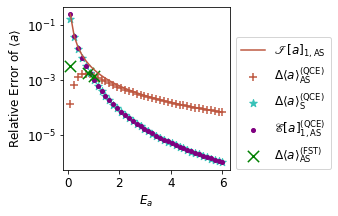

In [20]:
fig, axes = plt.subplots(1,1 , figsize=(3,3))

axes.set_xlabel(r'$E_a$');
axes.scatter(Ea,sol_re_dsh,c=cor2,s=64,marker = '+',label=r'$\Delta\langle a\rangle_{\mathrm{AS}}^{\mathrm{(QCE)}}$')
axes.scatter(Ea,sol_re_csh,c=cor1,s=64,marker = '*',label=r'$\Delta\langle a\rangle_{\mathrm{S}}^{\mathrm{(QCE)}}$')
axes.semilogy(Ea,np.real(sol_indicator),c=cor2,linestyle='-',label=r'$\mathscr{I}\,[a]_{1,\mathrm{AS}}$')
axes.scatter(Ea,np.abs(sol_re_dsh-np.real(sol_indicator)),linestyle='-',c=cor3,s=64,marker = '.',\
             label=r'$\mathscr{E}[a]^{\mathrm{(QCE)}}_{1,\mathrm{AS}}$')
axes.scatter(0.1,0.0032402336919848396,c=cor4,s=128,marker = 'x',label=r'$\Delta\langle a\rangle_{\mathrm{AS}}^{\mathrm{(FST)}}$')
axes.scatter(0.8,0.0018693903808554568,c=cor4,s=128,marker = 'x')
axes.scatter(1,0.0014401181650716133,c=cor4,s=128,marker = 'x')

axes.legend(bbox_to_anchor=(1.0, 0.85),ncol=1,loc=0,frameon=True); 

axes.set_ylabel(r'Relative Error of $\langle a\rangle$')   

### Various g constant $E_a$

In [38]:
##parameters
kappa_a=2
kappa_b=2
kappa_c=2
psi0_l=[0,0,0]
g=np.linspace(0.1,1,30);Eb=0.1; Ea=2
tlist=np.linspace(0,10,1000)

In [39]:
def CalG(E:float,g:complex,kappa:float):
    G=-2.0j*E*g/kappa
    return G

In [40]:
sol_dsh=np.zeros([np.size(g)],dtype=complex)
sol_csh=np.zeros([np.size(g)],dtype=complex)

In [41]:
data_csh=Data.Data([['AbC',1],['aBc',1],['A',1],['a',1],['B',Eb],['b',Eb]],\
               [['a',kappa_a],['b',kappa_b],['c',kappa_c]],['a'], 1)

In [42]:
data_com=Data.Data([['AbC',1],['aBc',1],['A',Ea],['a',Ea],['B',0.1],['b',0.1]],\
                  [['a',kappa_a],['b',kappa_b],['c',kappa_c]],['a'], 4)
sol_com=np.zeros([np.size(g)],dtype=complex)

In [43]:
sol_indicator=np.zeros([np.size(g)],dtype=complex)

In [44]:
ts=time.time()
for j in range(0,np.size(g)):
    G=CalG(Ea,g[j],kappa_a)
    data_com.SetCoefHOList([g[j],g[j],Ea,Ea,Eb,Eb])
    data_csh.SetCoefHOList([g[j],g[j],Ea,Ea,Eb,Eb])
    output_com=Solver.Solve(data_com,psi0_l,(0,tlist[-1]),t_eval=tlist,rtol=1e-10,atol=1e-12)
    output_csh=Solver.Solve(data_csh,psi0_l,(0,tlist[-1]),t_eval=tlist,rtol=1e-10,atol=1e-12)
    sol_dsh[j]=G/g[j]
    sol_csh[j]=output_csh.y[0][-1]
    sol_com[j]=output_com.y[0][-1]
    sol_indicator[j]=CalIndicator_a(Ea,g[j])
te=time.time()
print('Time cost:'+str(te-ts)+'s')

Time cost:237.30586647987366s


In [45]:
sol_re_dsh=np.abs((sol_com-sol_dsh)/sol_dsh)
sol_re_csh=np.abs((sol_com-sol_csh)/sol_csh)
RESID=np.real(sol_indicator)-sol_re_dsh

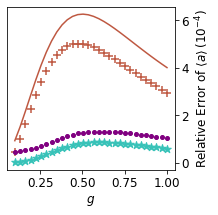

In [49]:
fig, axes = plt.subplots(1,1 , figsize=(3,3))

axes.set_xlabel(r'$g$');
axes.plot(g,np.real(sol_indicator)*1e4,c=cor2,linestyle='-',label=r'$\mathscr{I}\,[a]_{1,\mathrm{AS}}$')
axes.scatter(g,sol_re_dsh*1e4,c=cor2,s=64,marker = '+',label=r'$\Delta\langle a\rangle_{\mathrm{AS}}^{\mathrm{(QCE)}}$')
axes.scatter(g,RESID*1e4,linestyle='-',c='purple',s=64,marker = '.',label=r'$\mathscr{E}[a]^{\mathrm{(QCE)}}_{1,\mathrm{AS}}$')
axes.scatter(g,sol_re_csh*1e4,c=cor1,s=64,marker = '*',label=r'$\Delta\langle a\rangle_{\mathrm{S}}^{\mathrm{(QCE)}}$')
axes.yaxis.set_ticks_position('right') 
axes.yaxis.set_label_position("right")

axes.set_ylabel(r'Relative Error of $\langle a\rangle\,(10^{-4})$')   

## Symmetry

### Various $E_a$ constant g

In [13]:
##parameters
kappa_a=2
kappa_b=2
kappa_c=2
psi0_l=[0,0,0]
Ea=np.linspace(2,12,20);Eb=0.1; g=1
tlist=np.linspace(0,20,2000)

In [14]:
def CalG(E:float,g:complex,kappa:float):
    G=-2.0j*E*g/kappa
    return G

In [15]:
G=CalG(1,g,kappa_a)
G_c=np.conj(G).item()

In [16]:
data_dsh=Data.Data([['bC',G_c],['Bc',G],['B',0.1],['b',0.1]],\
               [['b',kappa_b],['c',kappa_c]],['b'], 2)
sol_dsh=np.zeros([np.size(Ea)],dtype=complex)

In [17]:
data_csh=Data.Data([['AbC',g],['aBc',g],['A',1],['a',1],['B',0.1],['b',0.1]],\
               [['a',kappa_a],['b',kappa_b],['c',kappa_c]],['b','a'], 1)
sol_csh=np.zeros([np.size(Ea)],dtype=complex)

In [18]:
data_com=Data.Data([['AbC',g],['aBc',g],['A',1],['a',1],['B',0.1],['b',0.1]],\
                  [['a',kappa_a],['b',kappa_b],['c',kappa_c]],['b'], 4)
sol_com=np.zeros([np.size(Ea)],dtype=complex)

In [19]:
sol_indicator_csh=np.zeros([np.size(Ea)],dtype=complex)
sol_indicator_dsh=np.zeros([np.size(Ea)],dtype=complex)

In [20]:
ts=time.time()
for j in range(0,np.size(Ea)):
    G=CalG(Ea[j],g,kappa_a)
    G_c=np.conj(G).item()
    data_csh.SetCoefHOList([g,g,Ea[j],Ea[j],Eb,Eb])
    data_com.SetCoefHOList([g,g,Ea[j],Ea[j],Eb,Eb])
    output_csh=Solver.Solve(data_csh,psi0_l,(0,tlist[-1]),t_eval=tlist,rtol=1e-10,atol=1e-12)
    output_com=Solver.Solve(data_com,psi0_l,(0,tlist[-1]),t_eval=tlist,rtol=1e-10,atol=1e-12)
    sol_dsh[j]=Cal_b(Eb,G)
    sol_csh[j]=output_csh.y[0][-1]
    sol_com[j]=output_com.y[0][-1]
    sol_indicator_csh[j]=CalIndicator_b_c_S(output_csh.y[1][-1],g)
    sol_indicator_dsh[j]=CalIndicator_b_AS(Eb,g,Ea[j])
te=time.time()
print('Time cost:'+str(te-ts)+'s')

Time cost:640.2859261035919s


In [21]:
sol_re_csh=np.abs((sol_com-sol_csh)/sol_csh)
sol_re_dsh=np.abs((sol_com-sol_dsh)/sol_dsh)

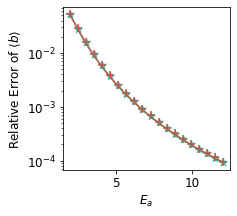

In [22]:
fig, axes = plt.subplots(1,1 , figsize=(3,3))

axes.set_xlabel(r'$E_a$');
axes.semilogy(Ea,np.real(sol_indicator_csh),c=cor1,linestyle='-',label=r'$\mathscr{I}\,[b]_{2,\mathrm{S}}$')
axes.semilogy(Ea,np.real(sol_indicator_dsh),c=cor2,linestyle='-',label=r'$\mathscr{I}\,[b]_{2,\mathrm{AS}}$')
axes.scatter(Ea,sol_re_csh,c=cor1,s=64,marker = '*',label=r'$\Delta\langle b\rangle_{\mathrm{S}}^{\mathrm{(QCE)}}$')
axes.scatter(Ea,sol_re_dsh,c=cor2,s=64,marker = '+',label=r'$\Delta\langle b\rangle_{\mathrm{AS}}^{\mathrm{(QCE)}}$')

axes.set_ylabel(r'Relative Error of $\langle b\rangle$')   

### Various g constant

In [23]:
##parameters
kappa_a=2
kappa_b=2
kappa_c=2
psi0_l=[0,0,0]
g=np.linspace(0.1,1,30);Eb=0.1; Ea=4
tlist=np.linspace(0,20,2000)

In [24]:
def CalG(E:float,g:complex,kappa:float):
    G=-2.0j*E*g/kappa
    return G

In [25]:
G=CalG(1,1,kappa_a)
G_c=np.conj(G).item()

In [26]:
data_dsh=Data.Data([['bC',G_c],['Bc',G],['B',0.1],['b',0.1]],\
               [['b',kappa_b],['c',kappa_c]],['b'], 2)
sol_dsh=np.zeros([np.size(g)],dtype=complex)

In [27]:
data_csh=Data.Data([['AbC',1],['aBc',1],['A',1],['a',1],['B',0.1],['b',0.1]],\
               [['a',kappa_a],['b',kappa_b],['c',kappa_c]],['b','a'], 1)
sol_csh=np.zeros([np.size(g)],dtype=complex)

In [28]:
data_com=Data.Data([['AbC',1],['aBc',1],['A',Ea],['a',Ea],['B',0.1],['b',0.1]],\
                  [['a',kappa_a],['b',kappa_b],['c',kappa_c]],['b'], 4)
sol_com=np.zeros([np.size(g)],dtype=complex)

In [29]:
sol_indicator_csh=np.zeros([np.size(g)],dtype=complex)
sol_indicator_dsh=np.zeros([np.size(g)],dtype=complex)

In [30]:
ts=time.time()
for j in range(0,np.size(g)):
    G=CalG(Ea,g[j],kappa_a)
    G_c=np.conj(G).item()
    data_csh.SetCoefHOList([g[j],g[j],Ea,Ea,Eb,Eb])
    data_com.SetCoefHOList([g[j],g[j],Ea,Ea,Eb,Eb])
    output_csh=Solver.Solve(data_csh,psi0_l,(0,tlist[-1]),t_eval=tlist,rtol=1e-10,atol=1e-12)
    output_com=Solver.Solve(data_com,psi0_l,(0,tlist[-1]),t_eval=tlist,rtol=1e-10,atol=1e-12)
    sol_dsh[j]=Cal_b(Eb,G)
    sol_csh[j]=output_csh.y[0][-1]
    sol_com[j]=output_com.y[0][-1]
    sol_indicator_csh[j]=CalIndicator_b_c_S(output_csh.y[1][-1],g[j])
    sol_indicator_dsh[j]=CalIndicator_b_AS(Eb,g[j],Ea)
te=time.time()
print('Time cost:'+str(te-ts)+'s')

Time cost:667.0048177242279s


In [31]:
sol_re_csh=np.abs((sol_com-sol_csh)/sol_csh)
sol_re_dsh=np.abs((sol_com-sol_dsh)/sol_dsh)

In [32]:
RESID=np.abs(np.real(sol_indicator_csh)-sol_re_csh)

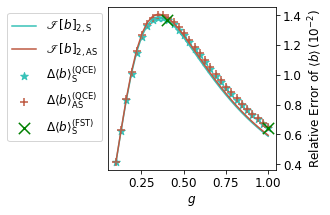

In [36]:
fig, axes = plt.subplots(1,1 , figsize=(3,3))

axes.set_xlabel(r'$g$');
axes.scatter(g,sol_re_csh*1e2,c=cor1,s=64,marker = '*',label=r'$\Delta\langle b\rangle_{\mathrm{S}}^{\mathrm{(QCE)}}$')
axes.plot(g,np.real(sol_indicator_csh)*1e2,c=cor1,linestyle='-',label=r'$\mathscr{I}\,[b]_{2,\mathrm{S}}$')
axes.scatter(g,sol_re_dsh*1e2,c=cor2,s=64,marker = '+',label=r'$\Delta\langle b\rangle_{\mathrm{AS}}^{\mathrm{(QCE)}}$')
axes.plot(g,np.real(sol_indicator_dsh)*1e2,c=cor2,linestyle='-',label=r'$\mathscr{I}\,[b]_{2,\mathrm{AS}}$')

axes.scatter(0.4, 0.013705379134684151*100,c='green',s=128,marker = 'x',label=r'$\Delta\langle b\rangle_{\mathrm{S}}^{\mathrm{(FST)}}$',zorder=3)
axes.scatter(1, 0.006407918598775892*100,c='green',s=128,marker = 'x',zorder=3)

axes.yaxis.set_ticks_position('right') 
axes.yaxis.set_label_position("right")

axes.legend(bbox_to_anchor=(0, 1.0),ncol=1,loc=0,frameon=True); 

axes.set_ylabel(r'Relative Error of $\langle b\rangle\,(10^{-2})$')   

## Singe Qutip Simulation For AS

In [37]:
##parameters
kappa_a=2
kappa_b=2
kappa_c=2
psi0_l=[0,0,0]
Ea=1;Eb=0.1; g=1

In [38]:
tlist=np.linspace(0,20,2000)

In [39]:
op=BuildOperator_Exact(Ea,Eb,g)

In [40]:
ts=time.time()
opts=Options()
opts.atol=1e-12
opts.rtol=1e-10
output=mesolve(op['Hamilton'],op['Initial_state'],tlist,op['Collapse'],op['track'],options=opts)
te=time.time()
print(te-ts)

1669.8237221240997


In [41]:
print('Error a='+str(np.abs((output.expect[2][-1]+2j*Ea/kappa_a)/(-2j*Ea/kappa_a))))

Error a=0.0014401181650716133
